## 1、导入相关包

In [3]:
import os
from tqdm import tqdm
# 数据科学包
import random                      # 随机切分数据集
import numpy as np                 # 常用数据科学包
from PIL import Image              # 图像读取
import matplotlib.pyplot as plt    # 代码中快速验证
import cv2                         # 图像包

# 深度学习包
import paddle
import paddle.vision.transforms as tf      # 数据增强
from paddle.io import Dataset, DataLoader  # 定义数据集
import paddle.nn as nn                     # 网络

## 2、准备数据集

解压数据集

In [6]:
if not os.path.exists('data/cat_12_train'):
    !unzip data/cat_12_train.zip
if not os.path.exists('data/cat_12_test'):
    !unzip data/cat_12_test.zip

  inflating: cat_12_train/P7UcXADFjgtImh3HClZixkaRLSnV0qve.jpg  
  inflating: cat_12_train/pA4u7fCHoO3vnWxcL1mGy8JqzXMwSa6j.jpg  
  inflating: cat_12_train/PaLepfEt1cx7unrOkZjUodlSJqiyRVFD.jpg  
  inflating: cat_12_train/paWDyCPL0G421AZzxlJn7ovfqRhVurw9.jpg  
  inflating: cat_12_train/pB3xZ9WIAXwSltg0yDCjEP1HVmKYT746.jpg  
  inflating: cat_12_train/PBydmvg26QWznof4xcbSLXEOZ8AiweUT.jpg  
  inflating: cat_12_train/Pc28kzNqEfY35s1xLFTMyd7neGaS6lKZ.jpg  
  inflating: cat_12_train/PC3ToHKLNBkOSmrJW45Xq7MR9yctIAZ0.jpg  
  inflating: cat_12_train/Pc5U1HSZTkF3rVezfCEmsM7gYW9LKoGX.jpg  
  inflating: cat_12_train/pcLq5UtkHdfg8KZv4Y0jGzJV9ax16yDh.jpg  
  inflating: cat_12_train/Pco9ArIimhTQn7YF0WGUHXEdBb3jCxkz.jpg  
  inflating: cat_12_train/PCVQeFpX14IwxBlWt9vz3g28yrASZRfH.jpg  
  inflating: cat_12_train/PdloD9mMJvX4I8nUeiChkTFE6RwOGabt.jpg  
  inflating: cat_12_train/pebD4UgWFBT8jcKJO1CHqQmGhkXYvAtL.jpg  
  inflating: cat_12_train/PEbGd6vAT9hZCqnVXrHMcLzwmpsODj2y.jpg  
  inflating: cat_12_train

划分数据集

In [9]:
train_ratio = 0.9  # 训练集占0.9，验证集占0.1

train_paths, train_labels = [], []
valid_paths, valid_labels = [], []
with open('data/train_list.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if random.uniform(0, 1) < train_ratio:
            train_paths.append('data/' + line.split('	')[0])
            label = line.split('	')[1]
            train_labels.append(int(line.split('	')[1]))
        else:
            valid_paths.append('data/' + line.split('	')[0])
            valid_labels.append(int(line.split('	')[1]))

定义数据集

In [10]:
# 定义训练数据集
class TrainData(Dataset):
    def __init__(self, train_paths, train_labels):
        super().__init__()
        self.train_paths = train_paths
        self.train_labels = train_labels
        self.color_jitter = tf.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05)
        self.normalize = tf.Normalize(mean=0, std=1)
        self.random_crop = tf.RandomCrop(224, pad_if_needed=True)
    
    def __getitem__(self, index):
        # 读取图片
        image_path = self.train_paths[index]
        # Height Weight Channel
        image = np.array(Image.open(image_path))    # H, W, C
        try:
            image = image.transpose([2, 0, 1])[:3]  # C, H, W
        except:
            image = np.array([image, image, image]) # single channel copies
        
        # 统一为 224*224
        image = cv2.resize(image.transpose((1, 2, 0)), (224, 224)).transpose([2, 0, 1])
        
        # 图像增广
        features = self.color_jitter(image.transpose([1, 2, 0]))
        features = self.random_crop(features)
        features = self.normalize(features.transpose([2, 0, 1])).astype(np.float32)

        # 读取标签
        labels = self.train_labels[index]

        return features, labels
    
    def __len__(self):
        return len(train_paths)
    
# 定义验证数据集
class ValidData(Dataset):
    def __init__(self, valid_paths, valid_labels):
        super().__init__()
        self.valid_paths = valid_paths
        self.valid_labels = valid_labels
        self.normalize = tf.Normalize(mean=0, std=1)
    
    def __getitem__(self, index):
        # 读取图片
        image_path = self.valid_paths[index]

        image = np.array(Image.open(image_path))    # H, W, C
        try:
            image = image.transpose([2, 0, 1])[:3]  # C, H, W
        except:
            image = np.array([image, image, image]) # single channel copies
        
        # 图像变换
        features = cv2.resize(image.transpose([1, 2, 0]), (224, 224)).transpose([2, 0, 1]).astype(np.float32)
        features = self.normalize(features)

        # 读取标签
        labels = self.valid_labels[index]

        return features, labels
    
    def __len__(self):
        return len(self.valid_paths)

查看对图像进行的增广变换


label: 11



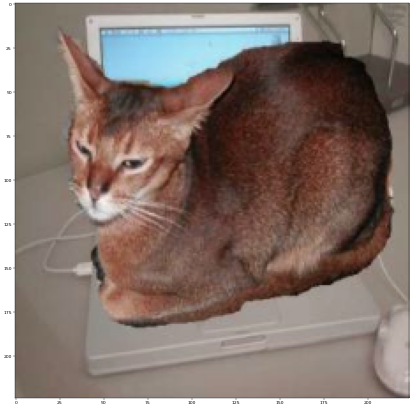

In [11]:
train_data = TrainData(train_paths, train_labels)
img, labels = train_data.__getitem__(98)
print('label: '+str(label))
plt.figure(dpi=32,figsize=(16,16))
plt.imshow(img.astype(np.uint8).transpose([1, 2, 0]))
plt.show()

label: 7


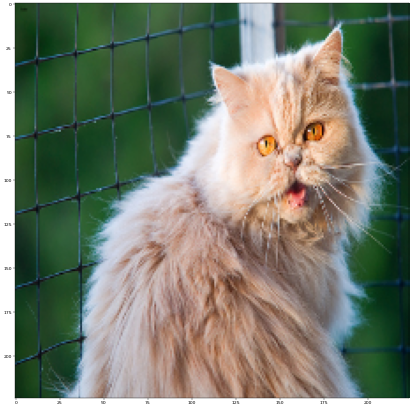

In [12]:
valid_data = ValidData(valid_paths, valid_labels)
img, label = valid_data.__getitem__(134)
print('label: '+str(label))
plt.figure(dpi=32,figsize=(16,16))
plt.imshow(img.astype(np.uint8).transpose([1, 2, 0]))

## 3、准备网络模型

搭建网络

In [13]:
# 定义VisionTransformer模型
# 图像分块、Embedding
class PatchEmbed(nn.Layer):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        # 原始大小为int，转为tuple，即：img_size原始输入224，变换后为[224,224]
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        # 图像块的个数
        num_patches = (img_size[1] // patch_size[1]) * \
            (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        # kernel_size=块大小，即每个块输出一个值，类似每个块展平后使用相同的全连接层进行处理
        # 输入维度为3，输出维度为块向量长度
        # 与原文中：分块、展平、全连接降维保持一致
        # 输出为[B, C, H, W]
        self.proj = nn.Conv2D(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            "Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        # [B, C, H, W] -> [B, C, H*W] ->[B, H*W, C]
        x = self.proj(x).flatten(2).transpose((0, 2, 1))
        return x

# Multi-head Attention
class Attention(nn.Layer):
    def __init__(self,
                 dim,
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop=0.,
                 proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5
        # 计算 q,k,v 的转移矩阵
        self.qkv = nn.Linear(dim, dim * 3, bias_attr=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        # 最终的线性层
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        N, C = x.shape[1:]
        # 线性变换
        qkv = self.qkv(x).reshape((-1, N, 3, self.num_heads, C //
                                   self.num_heads)).transpose((2, 0, 3, 1, 4))
        # 分割 query key value
        q, k, v = qkv[0], qkv[1], qkv[2]
        # Scaled Dot-Product Attention
        # Matmul + Scale
        attn = (q.matmul(k.transpose((0, 1, 3, 2)))) * self.scale
        # SoftMax
        attn = nn.functional.softmax(attn, axis=-1)
        attn = self.attn_drop(attn)
        # Matmul
        x = (attn.matmul(v)).transpose((0, 2, 1, 3)).reshape((-1, N, C))
        # 线性变换
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
    
class Mlp(nn.Layer):
    def __init__(self,
                 in_features,
                 hidden_features=None,
                 out_features=None,
                 act_layer=nn.GELU,
                 drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        # 输入层：线性变换
        x = self.fc1(x)
        # 应用激活函数
        x = self.act(x)
        # Dropout
        x = self.drop(x)
        # 输出层：线性变换
        x = self.fc2(x)
        # Dropout
        x = self.drop(x)
        return x
    
def drop_path(x, drop_prob=0., training=False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = paddle.to_tensor(1 - drop_prob)
    shape = (paddle.shape(x)[0], ) + (1, ) * (x.ndim - 1)
    random_tensor = keep_prob + paddle.rand(shape, dtype=x.dtype)
    random_tensor = paddle.floor(random_tensor)
    output = x.divide(keep_prob) * random_tensor
    return output

class DropPath(nn.Layer):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)
    
class Block(nn.Layer):
    def __init__(self,
                 dim,
                 num_heads,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop=0.,
                 attn_drop=0.,
                 drop_path=0.,
                 act_layer=nn.GELU,
                 norm_layer='nn.LayerNorm',
                 epsilon=1e-5):
        super().__init__()
        self.norm1 = eval(norm_layer)(dim, epsilon=epsilon)
        # Multi-head Self-attention
        self.attn = Attention(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop)
        # DropPath
        self.drop_path = DropPath(drop_path) if drop_path > 0. else Identity()
        self.norm2 = eval(norm_layer)(dim, epsilon=epsilon)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim,
                       hidden_features=mlp_hidden_dim,
                       act_layer=act_layer,
                       drop=drop)

    def forward(self, x):
        # Multi-head Self-attention， Add， LayerNorm
        x = x + self.drop_path(self.attn(self.norm1(x)))
        # Feed Forward， Add， LayerNorm
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

# 参数初始化配置
trunc_normal_ = nn.initializer.TruncatedNormal(std=.02)
zeros_ = nn.initializer.Constant(value=0.)
ones_ = nn.initializer.Constant(value=1.)

# 将输入 x 由 int 类型转为 tuple 类型
def to_2tuple(x):
    return tuple([x] * 2)

# 定义一个什么操作都不进行的网络层
class Identity(nn.Layer):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, input):
        return input

class VisionTransformer(nn.Layer):
    def __init__(self,
                 img_size=224,
                 patch_size=16,
                 in_chans=3,
                 class_dim=1000,
                 embed_dim=768,
                 depth=12,
                 num_heads=12,
                 mlp_ratio=4,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_rate=0.,
                 attn_drop_rate=0.,
                 drop_path_rate=0.,
                 norm_layer='nn.LayerNorm',
                 epsilon=1e-5,
                 **args):
        super().__init__()
        self.class_dim = class_dim

        self.num_features = self.embed_dim = embed_dim
        # 图片分块和降维，块大小为patch_size，最终块向量维度为768
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim)
        # 分块数量
        num_patches = self.patch_embed.num_patches
        # 可学习的位置编码
        self.pos_embed = self.create_parameter(
            shape=(1, num_patches + 1, embed_dim), default_initializer=zeros_)
        self.add_parameter("pos_embed", self.pos_embed)
        # 人为追加class token，并使用该向量进行分类预测
        self.cls_token = self.create_parameter(
            shape=(1, 1, embed_dim), default_initializer=zeros_)
        self.add_parameter("cls_token", self.cls_token)
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = np.linspace(0, drop_path_rate, depth)
        # transformer
        self.blocks = nn.LayerList([
            Block(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[i],
                norm_layer=norm_layer,
                epsilon=epsilon) for i in range(depth)
        ])

        self.norm = eval(norm_layer)(embed_dim, epsilon=epsilon)

        # Classifier head
        self.head = nn.Linear(embed_dim,
                              class_dim) if class_dim > 0 else Identity()

        trunc_normal_(self.pos_embed)
        trunc_normal_(self.cls_token)
        self.apply(self._init_weights)
    # 参数初始化
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            zeros_(m.bias)
            ones_(m.weight)
    
    def forward_features(self, x):
        B = paddle.shape(x)[0]
        # 将图片分块，并调整每个块向量的维度
        x = self.patch_embed(x)
        # 将class token与前面的分块进行拼接
        cls_tokens = self.cls_token.expand((B, -1, -1))
        x = paddle.concat((cls_tokens, x), axis=1)
        # 将编码向量中加入位置编码
        x = x + self.pos_embed
        x = self.pos_drop(x)
        # 堆叠 transformer 结构
        for blk in self.blocks:
            x = blk(x)
        # LayerNorm
        x = self.norm(x)
        # 提取分类 tokens 的输出
        return x[:, 0]

    def forward(self, x):
        # 获取图像特征
        x = self.forward_features(x)
        # 图像分类
        x = self.head(x)
        return x


vit = VisionTransformer(class_dim=12, embed_dim=256, depth=8, num_heads=8, drop_rate=0.2)


W0112 21:04:54.286906   388 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.8
W0112 21:04:54.288172   388 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.


查看网络结构

In [14]:
# print(vit)
# 获取模型结构文件
paddle.jit.save(vit, './model/vit_model', [paddle.static.InputSpec([None, 3, None, None])])

I0112 21:05:03.513242   388 program_interpreter.cc:212] New Executor is Running.


载入预训练模型

In [15]:
model = vit

pretrain_model_path = './model/transformer/final.pdparams'# 'pretrained_models/ResNet50_pretrained'

# 加载预训练模型参数
model.set_state_dict(paddle.load(pretrain_model_path))

([], [])

## 4、模型训练

In [16]:
epochs = 10
batch_size = 64

# 设置GPU环境，如果没有GPU则设置为CPU
if paddle.is_compiled_with_cuda() and paddle.get_device() != 'cpu':
    paddle.set_device('gpu:0')
    print("Using GPU.")
else:
    paddle.set_device('cpu')
    print("Using CPU.")

# 定义数据迭代器
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, drop_last=False)

# 定义优化器
opt = paddle.optimizer.Adam(learning_rate=1e-4, parameters=model.parameters(), weight_decay=paddle.regularizer.L2Decay(1e-4))

# 定义损失函数
loss_fn = paddle.nn.CrossEntropyLoss()

# 用于测量准确率的评价指标对象
metric =  paddle.metric.Accuracy()

# 定义 EarlyStopping 回调函数
callback = paddle.callbacks.EarlyStopping(monitor='acc', patience=5, mode='max', verbose=1)
# 定义 ModelCheckpoint 回调函数
checkpoint_callback = paddle.callbacks.ModelCheckpoint(save_dir='./model/cnn', save_freq=2)
# 设置 visualdl 路径
log_dir = './visualdl/transformer'
visual_callback = paddle.callbacks.VisualDL(log_dir=log_dir)

# 使用高层API进行训练
model = paddle.Model(model) # 用 Model 封装
# 模型配置
model.prepare(opt, loss_fn, metric)
# 模型训练
model.fit(train_dataloader,
          valid_dataloader,
          epochs=epochs,
          batch_size=batch_size,
          verbose=1,
          callbacks= [callback, checkpoint_callback, visual_callback])



Using GPU.
The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/10
step 31/31 [==============================] - loss: 0.5800 - acc: 0.8637 - 6s/step          
save checkpoint at /home/aistudio/model/cnn/0
Eval begin...
step 4/4 [==============================] - loss: 0.1009 - acc: 0.9904 - 5s/step
Eval samples: 208
Epoch 2/10
step 31/31 [==============================] - loss: 0.3756 - acc: 0.8770 - 5s/step          
Eval begin...
step 4/4 [==============================] - loss: 0.0545 - acc: 0.9808 - 3s/step
Eval samples: 208
Epoch 3/10
step 31/31 [==============================] - loss: 0.6207 - acc: 0.8934 - 4s/step          
save checkpoint at /home/aistudio/model/cnn/2
Eval begin...
step 4/4 [==============================] - loss: 0.0773 - acc: 0.9519 - 3s/step
Eval samples: 208
Epoch 4/10
step 31/31 [==============================] - loss: 0.4515 - acc: 0.8852 - 4s/step          
Eval begin...
step 4/4 [========

## 5、模型测试

模型预测

在测试集上预测，可以将生成的submit.csv文件提交比赛测试

In [17]:
# 预测文件的路径列表
def listdir(path, list_name):
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        if os.path.isdir(file_path):
            listdir(file_path, list_name)
        else:
            list_name.append(file_path)
test_path = []
listdir('data/cat_12_test', test_path)

# 加载训练好的模型
pre_model = paddle.vision.models.resnet50(pretrained=True, num_classes=12)
pre_model.set_state_dict(paddle.load('./model/transformer/final.pdparams'))
pre_model.eval()

pre_classes = []
normalize = tf.Normalize(mean=0, std=1)
# 生成预测结果
for path in test_path:
    image_path = path

    image = np.array(Image.open(image_path))    # H, W, C
    try:
        image = image.transpose([2, 0, 1])[:3]  # C, H, W
    except:
        image = np.array([image, image, image]) # C, H, W
    
    # 图像变换
    features = cv2.resize(image.transpose([1, 2, 0]), (256, 256)).transpose([2, 0, 1]).astype(np.float32)
    features = normalize(features)

    features = paddle.to_tensor([features])
    pre = list(np.array(pre_model(features)[0]))
    # print(pre)
    max_item = max(pre)
    pre = pre.index(max_item)
    # print("图片：", path, "预测结果：", pre)
    pre_classes.append(pre)

# print(pre_classes)

100%|██████████| 151272/151272 [00:03<00:00, 41296.65it/s]
/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/nn/layer/layers.py:2084: UserWarning: Skip loading for fc.weight. fc.weight receives a shape [2048, 1000], but the expected shape is [2048, 12].
  warnings.warn(f"Skip loading for {key}. " + str(err))
/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/nn/layer/layers.py:2084: UserWarning: Skip loading for fc.bias. fc.bias receives a shape [1000], but the expected shape is [12].
  warnings.warn(f"Skip loading for {key}. " + str(err))
/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/nn/layer/layers.py:2084: UserWarning: Skip loading for conv1.weight. conv1.weight is not found in the provided dict.
  warnings.warn(f"Skip loading for {key}. " + str(err))
/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/nn/layer/layers.py:2084: UserWarning: Skip loading for bn1.weight. bn1.weight is n

结果提交

In [18]:
# 导入csv模块
import csv

# 1、创建文件对象
with open('submit.csv', 'w', encoding='gbk', newline="") as f:
    # 2、基于文件对象构建csv写入对象
    csv_writer = csv.writer(f)
    for i in range(240):
        csv_writer.writerow([test_path[i].split('/')[2], pre_classes[i]])
    print('写入数据完成')

写入数据完成
